In [34]:
# Setup

import pandas as pd
import numpy as np
import requests
import os
import json
import matplotlib.pyplot as plt 
import warnings
%matplotlib inline
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import folium
from scipy.interpolate import griddata
from numpy import linspace
import geojsoncontour
import plotly.graph_objects as go
import cufflinks
from plotly.offline import iplot, plot


#Make the plots pretty
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='k'#'#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='k'#'#333F4B'
plt.rcParams['ytick.color']='k'#'#333F4B'
plt_txt = 10
plt.rcParams.update({'font.size': plt_txt})
blue = '#0091ea'
green = '#00c853'
orange = '#ffab00'

map_center = (37.993974, -98.927855) #lat lon of the center of the US

GET_URL = "https://api.is-conic.com/api/v0p1/debug/get_data"

# First, we'll load in data from our server and convert it into a pandas dataframe.

In [35]:
header = {"Content-Type": "application/json"}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    response = requests.request("GET", GET_URL, headers=header, verify=False)
if response.status_code != 200:
    raise Exception(response.status_code, response.text)
json_data = response.json()
df = pd.DataFrame.from_dict(json_data)

#look at data after March 9, 2021, Midnight PST (the number is that time in Unix time)
df = df[df['timestamp'] >= 1615276860]

# Next, we'll create a map image to show where all of our sensors are. 
## Click on one of the balloons to see more details

In [36]:
#TODO: account for mobile sensors. groupby id, get the last lat/lon. 
m = folium.Map(location=[map_center[0], map_center[1]], zoom_start=4, tiles="Stamen Terrain")

map_df = df.groupby('key', as_index=False)
#get the station name, unique units recorded, and last lat/lon
for name, grp in map_df:
    units = list(grp['unit'].unique())
    start = datetime.utcfromtimestamp(grp['timestamp'].min()).strftime("%m-%d")
    label = "Since: {}. Measures {}".format(start, ", ".join(units))
    folium.Marker([grp.iloc[-1]['lat'], grp.iloc[-1]['lon']], \
                  popup=label, tooltip=name).add_to(m)

#map_df = df.drop_duplicates(subset=['lat', 'lon'])

m

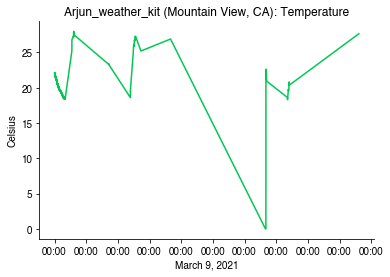

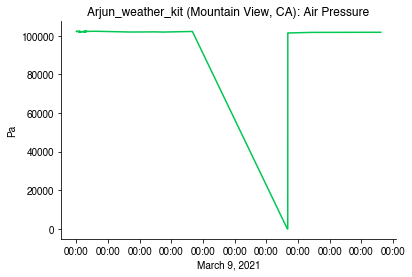

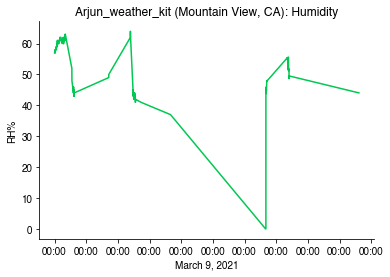

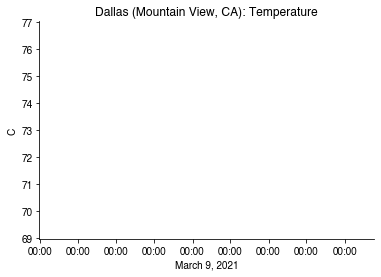

In [37]:
plot_df = df[~df['timestamp'].isna()].sort_values('timestamp', axis=0)
#convert to datetime. subtract 8 hours to get to PST
plot_df['timestamp'] = plot_df['timestamp'].apply(lambda x: \
    datetime.utcfromtimestamp(x-28800))
grouped = plot_df.groupby(['key', 'unit'], as_index=False)
date_form = DateFormatter("%H:%M")

unit_to_mode = {"Celsius":"Temperature", "Pa":"Air Pressure", "RH%":"Humidity", "C": "Temperature"}

for name, grp in grouped:
    if name[1] not in unit_to_mode:
        continue
    fig, ax = plt.subplots()  
    ax.plot('timestamp', 'value', color=green, data=grp)
    ax.set_title("{} (Mountain View, CA): {}".format(name[0], unit_to_mode[name[1]]))
    ax.set_ylabel(name[1])
    ax.set_xlabel("March 9, 2021")
    ax.xaxis.set_major_formatter(date_form)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    plt.show()

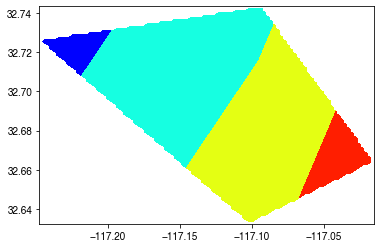

In [57]:
#this code is from https://towardsdatascience.com/visualizing-spatial-data-with-geojson-heatmaps-1fbe2063ab86

#have to select which measurement and the step size and min for the heatmap for its values
step_size = 5
value_min = 10
measurement_selected = "Celsius"

heatmap_df = df[~df['timestamp'].isna()].sort_values('timestamp', axis=0)
heatmap_df = heatmap_df[heatmap_df['unit'] == measurement_selected]
heatmap_df['timestamp'] = heatmap_df['timestamp'].apply(lambda x: \
    datetime.utcfromtimestamp(x-28800))
heatmap_df = heatmap_df.groupby(['key', 'unit'], as_index=False).mean()
#heatmap_df[heatmap_df['unit'] == measurement_selected]

#create fake heatmap data
idx = ["value", "lat", "lon"]
s1 = pd.Series([23, 32.632569, -117.102117], index=idx)
s2 = pd.Series([28, 32.664262, -117.015133], index=idx)
s3 = pd.Series([19, 32.743252, -117.092956], index=idx)
s4 = pd.Series([13, 32.726204, -117.247757], index=idx)
heatmap_df = pd.DataFrame([s1, s2, s3, s4])

heatmap_center = heatmap_df['lat'].mean(), heatmap_df['lon'].mean()
z = heatmap_df['value']
y = heatmap_df['lat']
x = heatmap_df['lon']

#Interpolating values to get better coverage
xi = linspace(x.min(),x.max(),100);
yi = linspace(y.min(),y.max(),100);
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')

cs = plt.contourf(xi,yi,zi,range(value_min, int( np.nanmax(zi))+step_size, step_size),cmap=plt.cm.jet)

In [58]:
#Creating contour plot with a step size of 1000
geojson = geojsoncontour.contourf_to_geojson(
    contourf=cs,
    ndigits=3,
)
#reading geojson as dict
heat_geojson=eval(geojson)

In [59]:
#Creating empty array to fill with heatmap values
arr_temp=np.ones([len(heat_geojson["features"]),2])

# for each region (aka "feature"), set its ID equal to i, and create a new array
# mapping those IDs to the lower bound of color bucket
for i in range(0, len(heat_geojson["features"])):
    heat_geojson["features"][i]["id"] = i
    arr_temp[i,0]=i
    bounds = heat_geojson["features"][i]["properties"]["title"]
    arr_temp[i,1] = bounds.split("-")[0]
    
#Transforming array to df
df_contour=pd.DataFrame(arr_temp, columns=["id","title"])

In [60]:
trace = go.Choroplethmapbox(geojson=heat_geojson,
                            locations=df_contour["id"],
                            z=df_contour["title"],
                            colorscale="jet",  
                            marker_line_width=0,
                            marker={'opacity': 0.5})

layout = go.Layout(
    title="{} Data".format(measurement_selected), title_x=0.4,
    height = 800,
    margin = dict(t = 80, b = 0, l = 0, r = 0),
    font = dict(color = 'dark grey', size = 18),
    
    mapbox = dict(center = {'lat': heatmap_center[0], 'lon': heatmap_center[1]},
        zoom = 11, style = "carto-positron"))

figure={'data': [trace], 'layout': layout}

plot(figure)

'temp-plot.html'